In [1]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd
pd.options.plotting.backend = "plotly"
import warnings
warnings.filterwarnings('ignore')

___
## 시계열 예측모델 : ARMA, ARIMA, SARIMA, VAR, VARMA 
___

In [2]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.api import VAR
from statsmodels.tools.eval_measures import rmse
from statsmodels.tsa.stattools import adfuller
# from statsmodels.tsa.stattools import acovf,acf,pacf,pacf_yw
# from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [3]:
# helper 함수 정의
def adf_test(series):
    result = adfuller(series)
    print(f'- ADF 통계량: {result[0]}')
    print(f'- p-value: {result[1]} ({'정상성 있음' if result[1] < 0.05 else '정상성 없음'})')
    print(f'- 지연수: {result[2]}')
    print(f'- 관찰수: {result[3]}')
    print('- 임계값:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
    

In [4]:
# 데이터 로드
df = pd.read_csv('Data/moneystock-spending-series.csv', index_col=0, parse_dates=True)
df.index.freq = 'MS'

## 1. 단일 시계열 분석 모델

#### <font color="orange">메타포 설명 : 오늘 기온을 예측하기 위해서, 최근7일간의 기온 데이터를 활용한다. 즉, 타겟변수를 예측할때 그 히스토리만 활용한다. </font>


### 🧠 ARMA / ARIMA 모델

> 과거의 **패턴** 과 **오차** 를 활용해서 미래를 예측하는 모델

---

### 📌 ARMA 모델이란?

ARMA는 다음 두 가지 모델을 결합한 것입니다

#### 1️⃣ AR(p): 자기회귀(AutoRegressive)

* 현재 시점의 값이 **과거의 값들** 에 영향을 받는 모델
* **예시**:
  "이번 달 매출은 지난달, 지지난달 매출과 비슷할 거야"

$$
Y_t = \phi_1 Y_{t-1} + \phi_2 Y_{t-2} + \cdots + \epsilon_t
$$

#### 2️⃣ MA(q): 이동 평균(Moving Average)

* 현재 시점의 값이 **과거의 예측 오차들** 에 영향을 받는 모델
* **예시**:
  "지난달 예측이 빗나갔는데, 이번 달도 그 영향이 있을 수 있어"

$$
Y_t = \epsilon_t + \theta_1 \epsilon_{t-1} + \theta_2 \epsilon_{t-2}
$$

---

### 💡 ARMA 모델 한 줄 정리

> **과거의 값(AR) + 과거의 예측오차(MA)** 를 조합해서 현재를 예측하는 모델

---

### 📌 ARIMA 모델이란?

> ARMA 모델은 기본적으로 **"정상 시계열"** 에만 적용 가능해요.
> 즉, **평균과 분산이 시간이 지나도 일정한 데이터** 에서만 잘 작동하죠.

하지만 현실 데이터(예: 집값, 주식, 유가 등)는 대개 **비정상적** 이죠.

그래서 등장한 것이:

#### 🔄 I(d): 차분(Integration)

* 데이터를 **차분**해서 정상 시계열로 만들어주는 단계
* **차분이란?**
  매 시점에서 **이전 시점 값을 빼주는 것**

$$
Y'_t = Y_t - Y_{t-1}
$$

* 예를 들어 집값이 매달 오를 때, 차분하면 "얼마나 올랐는가"만 남음 → 평균이 일정해짐

---

### ✅ 그래서 ARIMA란?

> \*\*ARIMA(p, d, q)\*\*는 다음을 의미.

| 기호 | 의미    | 설명                    |
| -- | ----- | --------------------- |
| p  | AR 차수 | 과거 몇 시점의 값들을 참고할 것인가? |
| d  | 차분 차수 | 몇 번 차분해야 데이터가 평평해질까?  |
| q  | MA 차수 | 과거 몇 시점의 오차를 고려할까?    |

---

### 🔢 수식은 어떻게 읽을까?

수식:

$$
Y_t = c + \epsilon_t + \sum_{i=1}^{p} \phi_i Y_{t-i} + \sum_{j=1}^{q} \theta_j \epsilon_{t-j}
$$

이건 그냥 이렇게 해석하면 됩니다.

> "현재 값은 일정한 평균 + 현재 오차 + 과거 값들의 영향 + 과거 오차들의 영향의 합이다"

---

### 🔄 백시프트 연산자란?

$$
B y_t = y_{t-1}
$$

즉, `B`는 "한 시점 전으로 이동"한다는 의미예요. 예를 들어,

* $B^2 y_t = y_{t-2}$

이걸 활용하면 복잡한 수식을 더 간단하게 표현할 수 있습니다.

---

### 🎯 예시

> 📈 **"주가 예측"**

* **AR(3)**: 주가는 지난 3일의 주가에 따라 움직인다
* **MA(2)**: 지난 2일의 예측 실수도 보정에 쓰인다
* **I(1)**: 주가는 상승 추세이므로 1번 차분해줘야 안정됨

→ **ARIMA(3,1,2)** 모델을 쓸 수 있음.


* 사용 예시

In [6]:
data = df['Money']
# ARIMA (1, 2, 1) 모델 피팅
model = ARIMA(data, order=(1, 2, 1))
fitted_model = model.fit()
print(fitted_model.summary())
# 예측
forecast = fitted_model.forecast(steps=12)
print(forecast)

                               SARIMAX Results                                
Dep. Variable:                  Money   No. Observations:                  252
Model:                 ARIMA(1, 2, 1)   Log Likelihood               -1176.729
Date:                Sat, 07 Jun 2025   AIC                           2359.458
Time:                        15:00:09   BIC                           2370.023
Sample:                    01-01-1995   HQIC                          2363.710
                         - 12-01-2015                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2229      0.042      5.297      0.000       0.140       0.305
ma.L1         -0.9481      0.021    -45.132      0.000      -0.989      -0.907
sigma2       712.5495     33.501     21.270      0.0

### **SARIMA**
ARIMA에 \*\*"계절성(Seasonality)"\*\*이라는 개념이 추가된 모델입니다. 수식도 어려워 보이지만, 핵심만 알면 정말 단순합니다.

---

#### ❓ ARIMA가 뭐였죠?

> 과거의 **값(AR)**, **예측오차(MA)**, \*\*추세를 제거하기 위한 차분(I)\*\*을 조합해서
> 미래 값을 예측하는 모델

하지만 현실 데이터엔 이런 게 자주 등장합니다.

> 📅 **매년 여름엔 아이스크림 매출이 늘어난다**
> 📅 **매달 말에는 교통량이 늘어난다**

이처럼, 주기적으로 반복되는 패턴 = **계절성(seasonality)**

---

#### 🎯 그래서 등장한 SARIMA!

> **SARIMA** = **Seasonal ARIMA**
> ARIMA에 **계절적인 AR / I / MA 성분을 추가**한 것

---

#### 📦 쉽게 SARIMA 구조 이해하기

##### 📌 일반 ARIMA(p, d, q)

* **p**: 과거 **값들(AR)** 몇 개를 쓸까?
* **d**: **몇 번 차분(I)** 해야 평평해질까?
* **q**: 과거 **오차들(MA)** 몇 개를 쓸까?

##### 📌 SARIMA(p, d, q)(P, D, Q, s)

여기에 아래를 추가:

| 기호    | 설명                                         |
| ----- | ------------------------------------------ |
| **P** | **계절적 AR** 성분 (예: 1년 전, 12개월 전 값을 활용)      |
| **D** | **계절 차분** 횟수                               |
| **Q** | **계절적 MA** 성분                              |
| **s** | **계절 주기** (예: 12 = 12개월, 4 = 분기, 7 = 주간 등) |

---

#### 🔢 수식 쉽게 보기

$$
\Phi(B) \cdot \Phi_s(B^s) \cdot (1 - B)^d \cdot (1 - B^s)^D y_t = \Theta(B) \cdot \Theta_s(B^s) \cdot \varepsilon_t
$$

하나씩 뜯어봅시다:

| 수식 요소           | 쉽게 설명                            |
| --------------- | -------------------------------- |
| $\Phi(B)$       | 일반 AR (과거값 기반 예측)                |
| $\Phi_s(B^s)$   | **계절적 AR** (예: 12개월 전, 24개월 전 값) |
| $(1 - B)^d$     | 일반 차분 (추세 제거)                    |
| $(1 - B^s)^D$   | **계절 차분** (계절 패턴 제거)             |
| $\Theta(B)$     | 일반 MA (과거 오차 기반 보정)              |
| $\Theta_s(B^s)$ | **계절적 MA** (계절 주기마다 오차 보정)       |

---

#### 🍦 예시

> **월별 아이스크림 판매량 예측** (12개월 단위로 계절성 있음)

* **ARIMA(1,1,1)**

  * 최근 1개월 값과 1차 차분, 최근 1개월 오차로 예측

* **SARIMA(1,1,1)(1,1,1,12)**

  * 일반 ARIMA 구성 +
  * **12개월 전 패턴** + **12개월 전 오차** + **1년 단위의 차분** 포함

이 모델은 **최근 정보와 과거 계절 정보를 모두 고려**해서 예측합니다.

---

#### 🧠 결론

> **SARIMA**는 ARIMA에 **계절 반복 패턴을 고려한 요소(P, D, Q, s)** 를 더한 모델

---

#### ✅ 정리 표

| 구성 요소   | 의미            | 예시             |
| ------- | ------------- | -------------- |
| p, d, q | ARIMA 기본 구성   | 추세 반영          |
| P, D, Q | 계절 AR, 차분, MA | 계절 패턴 반영       |
| s       | 계절 주기         | 월별이면 12, 분기면 4 |


#### 🎯 SARIMAX란?

> **SARIMA + 외생 변수(exogenous variables, X)**
> 즉, **계절성과 외부 요인**을 모두 반영하는 시계열 예측 모델입니다.

**SARIMAX = Seasonal ARIMA with eXogenous variables**

---

#### 🔍 먼저 기억해야 할 것

* **ARIMA**는 과거 자기 데이터(Y)만 보고 예측
* **SARIMA**는 여기에 계절성까지 추가
* 그런데, 현실에서는 외부 요인이 큰 영향을 줄 수 있어요

> 예:
> ❄️ “겨울엔 기온이 낮아지면 난방비가 오른다”
> 📈 “환율이 변하면 수출입 물가가 바뀐다”

→ 이런 \*\*외부 요인(기온, 환율 등)\*\*이 있을 때, SARIMA만으론 부족

---

#### ✅ 그래서 나온 게 SARIMAX!

> SARIMAX는 이렇게 예측합니다.

> "Y의 과거값, 계절성, 오차 패턴"뿐 아니라
> "외부에서 주어진 X(기온, 환율 등)"도 함께 고려해서 예측

---

#### 📌 수식 구조 (쉽게)

$$
Y_t = \text{SARIMA 부분} + \beta X_t + \varepsilon_t
$$

* **SARIMA 부분**: Y의 과거값, 계절성, 오차 항 등
* **X\_t**: 외생 변수 (설명 변수, 다른 시계열 데이터)
* **β**: 외생 변수의 계수
* **ε**: 오차

---

#### 📦 예시

##### 예시 1: 난방비 예측

> **Y\_t**: 월별 난방비
> **X\_t**: 그 달의 평균 기온 (외생 변수)

* **SARIMA**는 난방비의 계절적 패턴을 반영
* **SARIMAX**는 여기에 \*\*기온(X\_t)\*\*이라는 외부 변수도 고려

→ 기온이 낮은 달에는 난방비가 높을 것이라는 관계도 모델에 포함

---

#### 🤖 언제 SARIMAX를 쓰나요?

| 상황                  | 모델      |
| ------------------- | ------- |
| 시계열 데이터에 **추세**만 있음 | ARIMA   |
| **계절성**도 있음         | SARIMA  |
| **외부 요인도 영향** 줌     | SARIMAX |

---

#### 🧠 요약 정리

| 모델      | 고려 요소        | 설명          |
| ------- | ------------ | ----------- |
| ARIMA   | 과거 Y, 오차, 추세 | 기본적인 시계열 예측 |
| SARIMA  | + 계절성        | 계절 패턴까지 반영  |
| SARIMAX | + 외생 변수(X)   | 외부 요인도 반영   |

---

#### 🛠️ 실전에서 어떻게 쓰나요?

```python
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(y, exog=X, order=(p,d,q), seasonal_order=(P,D,Q,s))
result = model.fit()
forecast = result.predict(start, end, exog=X_future)
```

---

In [8]:
# SARIMA (1, 1, 1)x(1, 1, 1, 12) 모델 피팅
sarima_model = SARIMAX(data, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12)) # SARIMAX는 SARIMA에서 외생변수 처리까지 구현된 클래스. 여기서는 외생변수 고려하지 않음.
sarima_fitted_model = sarima_model.fit()
print(sarima_fitted_model.summary())
# 예측
sarima_forecast = sarima_fitted_model.forecast(steps=12)
print(sarima_forecast)

                                     SARIMAX Results                                      
Dep. Variable:                              Money   No. Observations:                  252
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -1145.526
Date:                            Sat, 07 Jun 2025   AIC                           2301.053
Time:                                    15:05:22   BIC                           2318.435
Sample:                                01-01-1995   HQIC                          2308.057
                                     - 12-01-2015                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8873      0.061     14.552      0.000       0.768       1.007
ma.L1         -0.6501      0.083   

/Users/dante/workspace/dante-code/projects/kmu-practical-ds-2025/.conda/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX(1, 1, 1)x(1, 1, 1, 12) 모형 결과 요약

- AR(1) 계수(0.8873)는 1에 가까워 시계열이 강한 자기상관을 가짐을 의미합니다.
- MA(1) 계수(-0.6501)는 음수로, 최근 오차가 반대 방향으로 영향을 미침을 보여줍니다.
- 계절 AR(12) 계수(0.0119)는 거의 0에 가까워 계절 자기상관 효과가 미미함을 시사합니다.
- 계절 MA(12) 계수(-0.9985)는 -1에 가까우나, 표준오차가 커서 통계적으로 유의하지 않습니다.
- 잔차의 분산(sigma2)은 733.83으로, 예측 오차의 크기를 나타냅니다.

진단지표
- Ljung-Box 검정(p=0.72): 잔차에 자기상관이 없으므로 모형이 적합함을 의미합니다.
- Jarque-Bera(p=0.00): 잔차가 정규분포를 따르지 않음을 의미합니다(왜도, 첨도 높음).
- Heteroskedasticity(p=0.00): 잔차의 분산이 일정하지 않음을 시사합니다.

예측값(2016년 1월~12월)
- 2016-01: 12383.86
- 2016-02: 12434.11
- 2016-03: 12476.78
- 2016-04: 12523.38
- 2016-05: 12562.85
- 2016-06: 12603.66
- 2016-07: 12651.41
- 2016-08: 12701.91
- 2016-09: 12741.18
- 2016-10: 12782.17
- 2016-11: 12818.21
- 2016-12: 12865.04

해석

> 이 SARIMAX 모형은 시계열의 자기상관(AR)과 오차항(MA), 그리고 계절적 패턴을 모두 반영합니다.
>
> AR 계수가 높아 과거 값의 영향이 크고, MA 계수는 최근 오차가 반대 방향으로 영향을 미침을 보여줍니다. 
>
> 계절성 효과는 통계적으로 유의하지 않으나, 계절 MA 계수는 -1에 가까워 일부 계절적 변동을 포착할 수 있습니다. 
>
> 잔차의 정규성 및 등분산성 가정은 다소 위배되었으나, 자기상관은 없으므로 예측에는 큰 무리가 없습니다.
>
> 2016년 한 해 동안 예측값은 완만하게 증가하는 추세를 보입니다.


___
## 2. 다변량 시계열 분석 모델

#### <font color="orange">메타포 설명 : 오늘 기온을 예측하기 위해서, 최근 7일간의 기온 데이터 뿐 아니라, 7일간의 풍속, 습도 데이터를 활용한다. </font>

#### <font color="orange">즉, 타겟변수를 예측할때 해당변수 및 해당변수와 연관된 변수의 히스토리까지 고려한다. </font>

___
### VAR (Vector Autoregression) 모델 (벡터 자기회귀 모형)
___
VAR 모델은 다변량 시계열 데이터를 다루는 모델. 

각 시계열 변수는 다른 변수들과의 관계를 고려하여 모델링됨.

$y_{t} = c + \phi_{1}y_{t-1} + \phi_{2}y_{t-2} + \dots + \phi_{p}y_{t-p} + \varepsilon_{t}$


* <font color="orange"> 2차원 VAR(1) 모델 예시</font>

    $y_{1,t} = c_1 + \phi_{11,1}y_{1,t-1} + \phi_{12,1}y_{2,t-1} + \varepsilon_{1,t}$<br>
    
    $y_{2,t} = c_2 + \phi_{21,1}y_{1,t-1} + \phi_{22,1}y_{2,t-1} + \varepsilon_{2,t}$

    #### $\begin{pmatrix} y_{1,t} \\ y_{2,t} \end{pmatrix} = \begin{pmatrix} c_1 \\ c_2 \end{pmatrix} + \begin{pmatrix} \phi_{11,1} & \phi_{12,1} \\ \phi_{21,1} & \phi_{22,1} \end{pmatrix} \begin{pmatrix} y_{1,t-1} \\ y_{2,t-1} \end{pmatrix} + \begin{pmatrix} \varepsilon_{1,t} \\ \varepsilon_{2,t} \end{pmatrix} $

* <font color="orange"> 3차원 VAR(2) 모델 예시 </font>

    $y_{1,t} = c_1 + \phi_{11,1}y_{1,t-1} + \phi_{12,1}y_{2,t-1} + \phi_{13,1}y_{3,t-1} + \phi_{11,2}y_{1,t-2} + \phi_{12,2}y_{2,t-2} + \phi_{13,2}y_{3,t-2} + \varepsilon_{1,t}$<br>

    $y_{2,t} = c_2 + \phi_{21,1}y_{1,t-1} + \phi_{22,1}y_{2,t-1} + \phi_{23,1}y_{3,t-1} + \phi_{21,2}y_{1,t-2} + \phi_{22,2}y_{2,t-2} + \phi_{23,2}y_{3,t-2} + \varepsilon_{2,t}$<br>

    $y_{3,t} = c_3 + \phi_{31,1}y_{1,t-1} + \phi_{32,1}y_{2,t-1} + \phi_{33,1}y_{3,t-1} + \phi_{31,2}y_{1,t-2} + \phi_{32,2}y_{2,t-2} + \phi_{33,2}y_{3,t-2} + \varepsilon_{3,t}$<br><br>

    #### $ \begin{pmatrix} y_{1,t} \\ y_{2,t} \\ y_{3,t} \end{pmatrix} = \begin{pmatrix} c_1 \\ c_2 \\ c_3 \end{pmatrix} + \begin{pmatrix} \phi_{11,1} & \phi_{12,1} & \phi_{13,1} \\ \phi_{21,1} & \phi_{22,1} & \phi_{23,1} \\ \phi_{31,1} & \phi_{32,1} & \phi_{33,1} \end{pmatrix} \begin{pmatrix} y_{1,t-1} \\ y_{2,t-1} \\ y_{3,t-1} \end{pmatrix} + \begin{pmatrix} \phi_{11,2} & \phi_{12,2} & \phi_{13,2} \\ \phi_{21,2} & \phi_{22,2} & \phi_{23,2} \\ \phi_{31,2} & \phi_{32,2} & \phi_{33,2} \end{pmatrix} \begin{pmatrix} y_{1,t-2} \\ y_{2,t-2} \\ y_{3,t-2} \end{pmatrix} + \begin{pmatrix} \varepsilon_{1,t} \\ \varepsilon_{2,t} \\ \varepsilon_{3,t} \end{pmatrix} $

* 모델 사용 예시

In [11]:
df.head()

,Money,Spending
Date,,
1995-01-01,3492.4,4851.2
1995-02-01,3489.9,4850.8
1995-03-01,3491.1,4885.4
1995-04-01,3499.2,4890.2
1995-05-01,3524.2,4933.1


In [10]:
# VAR 모델 피팅
model = VAR(df)
fitted_model = model.fit(maxlags=15, ic='aic')

# 모델 요약 출력
print(fitted_model.summary())


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 07, Jun, 2025
Time:                     15:10:48
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    13.8778
Nobs:                     247.000    HQIC:                   13.6911
Log likelihood:          -2354.26    FPE:                    778666.
AIC:                      13.5652    Det(Omega_mle):         713683.
--------------------------------------------------------------------
Results for equation Money
                 coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------
const              -3.578575        10.765839           -0.332           0.740
L1.Money            1.166264         0.064984           17.947           0.000
L1.Spending        -0.128001         0.049702           -2.575      

* VAR(5) 모델의 회귀 결과 해석

    * Money(통화량) 방정식:
      - 상수항(const)은 -3.58로, 통계적으로 유의하지 않습니다(p=0.74).
      - L1.Money(1시차 통화량)의 계수는 1.17로, 매우 유의하며(p<0.001), 이전 달 통화량이 현재 통화량에 강한 양의 영향을 미칩니다.
      - L1.Spending(1시차 소비)의 계수는 -0.13으로, 유의미하게(p=0.01) 음의 영향을 미칩니다. 즉, 지난달 소비가 많으면 이번 달 통화량은 약간 줄어드는 경향이 있습니다.
      -  L4.Money(4시차 통화량)의 계수는 -0.26으로, 유의미하게(p=0.011) 음의 영향을 미칩니다.
      - L4.Spending(4시차 소비)의 계수는 0.15로, 유의미하게(p=0.027) 양의 영향을 미칩니다.
      - L5.Spending(5시차 소비)의 계수는 -0.13으로, 유의미하게(p=0.008) 음의 영향을 미칩니다.
      - 나머지 시차 변수들은 통계적으로 유의하지 않습니다.

    * Spending(소비) 방정식:
      - 상수항(const)은 32.63으로, 유의미하게 양의 값을 가집니다(p=0.023).
      - L1.Money(1시차 통화량)의 계수는 0.17로, 유의수준 0.05에서 약간 아슬아슬하게(p=0.053) 양의 영향을 미칩니다.
      - L1.Spending(1시차 소비)의 계수는 1.01로, 매우 유의하며(p<0.001), 지난달 소비가 이번 달 소비에 강한 양의 영향을 미칩니다.
      - L2.Money(2시차 통화량)의 계수는 -0.24로, 유의수준 0.1에서 약간 음의 영향을 미칩니다(p=0.072).
      - 나머지 변수들은 통계적으로 유의하지 않습니다.

      잔차 상관행렬을 보면, Money와 Spending의 잔차 간 상관계수는 -0.24로, 약한 음의 상관관계를 보입니다.

    * 요약: 
      - 통화량과 소비 모두 자기 자신의 1시차 값에 강하게 영향을 받습니다(자기회귀적 특성).
      - 소비가 증가하면 단기적으로 통화량이 줄어드는 경향이 있고, 통화량이 증가하면 소비도 약간 증가하는 경향이 있습니다.
      - 일부 시차(4, 5시차)에서도 유의한 영향이 나타나므로, 단기뿐 아니라 중기적 영향도 존재합니다.


---

###  VARIMA / VARMAX란?

#### 🔍 VARIMA란?



VARMA 모델은 다변량 시계열 데이터를 다루며, VAR 모델에 이동 평균 성분을 추가한 모델

$ Y_t = c + A_1 Y_{t-1} + A_2 Y_{t-2} + \cdots + A_p Y_{t-p} + \epsilon_t \textcolor{orange}{+ \sum_{j=1}^{q} \Theta_j \epsilon_{t-j}} $


#### 🔍 VARIMAX란?
> 여러 개의 시계열(Y₁, Y₂, …)을 동시에 예측하면서
> 그들 사이의 상호 영향 + 이동평균(MA) + 외부 요인(X)까지 고려하는 다변량 시계열 예측 모델입니다.

---



##### ✅ 언제 VARMAX를 쓰나요?

> 예: "소비자 물가(Y₁)"와 "환율(Y₂)"이 서로 영향을 주고,
> 거기에 "국제유가(X)" 같은 외부 변수도 함께 반영하고 싶을 때

| 요소      | 설명                        |
| ------- | ------------------------- |
| **VAR** | 두 개 이상의 시계열이 서로 영향을 주는 구조 |
| **MA**  | 과거 예측오차를 반영               |
| **X**   | 외부 변수 반영 (예: 유가, 금리 등)    |

→ **VARMAX**는 이 세 가지를 **동시에 고려**하는 강력한 다변량 예측 모델입니다.

* <font color="orange"> 2차원 VARMA(2,1) 모델 예시 </font>

#### $\begin{pmatrix} y_{1,t} \\ y_{2,t} \end{pmatrix}\begin{pmatrix} c_1 \\ c_2 \end{pmatrix}+\begin{pmatrix} \phi_{11,1} & \phi_{12,1} \\ \phi_{21,1} & \phi_{22,1} \end{pmatrix}\begin{pmatrix} y_{1,t-1} \\ y_{2,t-1} \end{pmatrix}+\begin{pmatrix} \phi_{11,2} & \phi_{12,2} \\ \phi_{21,2} & \phi_{22,2} \end{pmatrix}\begin{pmatrix} y_{1,t-2} \\ y_{2,t-2} \end{pmatrix} \textcolor{orange}{+\begin{pmatrix} \theta_{11,1} &\theta_{12,1} \\ \theta_{21,1} & \theta_{22,1} \end{pmatrix}\begin{pmatrix} \varepsilon_{1,t-1} \\ \varepsilon_{2,t-1} \end{pmatrix}}+\begin{pmatrix} \varepsilon_{1,t} \\ \varepsilon_{2,t} \end{pmatrix}$

In [15]:
from statsmodels.tsa.statespace.varmax import VARMAX

In [16]:
# VARMA 모델 피팅
model = VARMAX(df, order=(2, 1))
fitted_model = model.fit(disp=False)

# 모델 요약 출력
print(fitted_model.summary())

# 예측
n_forecast = 10
forecast = fitted_model.forecast(steps=n_forecast)
print(forecast)


/Users/dante/workspace/dante-code/projects/kmu-practical-ds-2025/.conda/lib/python3.12/site-packages/statsmodels/tsa/statespace/varmax.py:160: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'


                             Statespace Model Results                            
Dep. Variable:     ['Money', 'Spending']   No. Observations:                  252
Model:                        VARMA(2,1)   Log Likelihood               -2447.417
                             + intercept   AIC                           4928.833
Date:                   Sat, 07 Jun 2025   BIC                           4988.833
Time:                           15:20:46   HQIC                          4952.976
Sample:                       01-01-1995                                         
                            - 12-01-2015                                         
Covariance Type:                     opg                                         
Ljung-Box (L1) (Q):             0.39, 3.58   Jarque-Bera (JB):       433.32, 131.83
Prob(Q):                        0.53, 0.06   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         3.52, 0.89   Skew:                       1.16, 0.05
Prob(H) (t

/Users/dante/workspace/dante-code/projects/kmu-practical-ds-2025/.conda/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


----
----

| 특징        | ARIMA                                      | VARMA                                           |
|-------------|--------------------------------------------|-------------------------------------------------|
| 데이터 유형 | 단일 시계열 데이터                         | 다중 시계열 데이터                              |
| 구성 요소   | AR (자기회귀), I (차분), MA ㅡ(이동평균)     | VAR (벡터 자기회귀), VMA (벡터 이동평균)        |
| 모델 형태   | ARIMA(p, d, q)                             | VARMA(p, q)                                     |
| 적용 예시   | 주식 가격, 온도 변화, 판매량 등            | 경제 지표, 여러 주식의 가격 변동, 기후 데이터 등|

----
----

___
## VAR / AR 예측 모델 실습
___

데이터 시각화

In [17]:
px.line(df, x=df.index, y=df.columns, title="M2 통화량 및 개인 소비").show()

In [18]:
# 정상성이 전제되어야 ARIMA 계열 모델을 사용할수 있다고 지난 수업시간 설명했습니다.
# 이유는 AR의 경우 타입스텝 각 시점마다 평균과 분산이 일정해야, 바로 이전 타입스텝과의 관계성을 회귀식으로 정의할수 있고,
# MA의 경우, 과거 시점의 오차 값을 이용해서 편재 시점의 값을 예측하는데, 평균 변동성은 오차패턴의 변동성을 만들게 되어, 과거오차 기반 예측이 불안정해지기 때문입니다.

오리지널 데이터 정상성검정

In [19]:
adf_test(df['Money']);
print()
adf_test(df['Spending']);

- ADF 통계량: 4.239022425670647
- p-value: 1.0 (정상성 없음)
- 지연수: 4
- 관찰수: 247
- 임계값:
	1%: -3.457
	5%: -2.873
	10%: -2.573

- ADF 통계량: 0.14979608598625144
- p-value: 0.969300994442831 (정상성 없음)
- 지연수: 3
- 관찰수: 248
- 임계값:
	1%: -3.457
	5%: -2.873
	10%: -2.573


1차 차분 데이터 정상성 검정

In [20]:
# 1차 차분
df_transformed = df.diff().dropna()

In [21]:
adf_test(df_transformed['Money']);
print()
adf_test(df_transformed['Spending']);

- ADF 통계량: -2.0574040497379373
- p-value: 0.2619837978511253 (정상성 없음)
- 지연수: 15
- 관찰수: 235
- 임계값:
	1%: -3.458
	5%: -2.874
	10%: -2.573

- ADF 통계량: -7.226973930850659
- p-value: 2.04102725921286e-10 (정상성 있음)
- 지연수: 2
- 관찰수: 248
- 임계값:
	1%: -3.457
	5%: -2.873
	10%: -2.573


2차 차분 데이터 정상성 검정

In [22]:
# 2차 차분
df_transformed = df_transformed.diff().dropna()
adf_test(df_transformed['Money']);
print()
adf_test(df_transformed['Spending']);

- ADF 통계량: -7.077470794343004
- p-value: 4.760674931296479e-10 (정상성 있음)
- 지연수: 14
- 관찰수: 235
- 임계값:
	1%: -3.458
	5%: -2.874
	10%: -2.573

- ADF 통계량: -8.760145426337745
- p-value: 2.6878999679867176e-14 (정상성 있음)
- 지연수: 8
- 관찰수: 241
- 임계값:
	1%: -3.458
	5%: -2.874
	10%: -2.573


데이터 분할

- 여기서 데이터 분할을 sklearn의 train_test_split 함수 등을 사용하지 않는 이유는, <font color="yellow">시간순 정렬의 shuffle이 일어나서는 안되기 때문</font>입니다.(시계열 분석의 특징)

In [23]:
# 테스트셋의 12개의 타임스텝으로 만들고, 예측시, 이 12개의 타임스텝을 싱글샷으로 예측할 예정입니다.
nobs=12
train, test = df_transformed[0:-nobs], df_transformed[-nobs:]

In [24]:
print(train.shape)
print(test.shape)

(238, 2)
(12, 2)


AIC지표 기반 VAR 최적모델 파인더 실행

 - AIC (Akaike Information Criterion)
  
   - 값이 낮을수록 더 좋은 모델을 의미.  

   - AIC는 모델의 복잡도와 적합도를 모두 고려하여 계산됩니다.
   - 공식 : $ \text{AIC} = 2k - 2\ln(L) $ ( $k$는 복잡도, $L$은 설명력(우도)을 의미 )

In [25]:
def find_best_model(train, max_order):
    best_aic = float('inf')
    best_order = None
    model = VAR(train)
    for i in range(1, max_order+1):
        results = model.fit(i)
        if results.aic < best_aic:
            best_aic = results.aic
            best_order = i
    return model, best_order

model, best_order = find_best_model(train, max_order=7)
print('Best Order =', best_order)

Best Order = 5


In [26]:
# 모델에 있는 변수들의 이름을 확인합니다.
model.endog_names

['Money', 'Spending']

모델링

In [27]:
results = model.fit(5)
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 07, Jun, 2025
Time:                     15:21:40
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    14.1131
Nobs:                     233.000    HQIC:                   13.9187
Log likelihood:          -2245.45    FPE:                    972321.
AIC:                      13.7873    Det(Omega_mle):         886628.
--------------------------------------------------------------------
Results for equation Money
                 coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------
const               0.516683         1.782238            0.290           0.772
L1.Money           -0.646232         0.068177           -9.479           0.000
L1.Spending        -0.107411         0.051388           -2.090      

In [28]:
print('모델 차수:', results.k_ar)

모델 차수: 5


예측

In [29]:
# 다음 12개의 값을 예측합니다.
forecast = results.forecast(train.values[-results.k_ar:], steps=nobs)
forecast_df = pd.DataFrame(forecast, index=pd.date_range(start=train.index[-1], periods=nobs+1, freq='MS')[1:], columns=train.columns)

print("Forecasted values for the next 12 periods:")
print(forecast_df)


Forecasted values for the next 12 periods:
                Money   Spending
2015-01-01 -16.995276  36.149820
2015-02-01  -3.174038 -11.450298
2015-03-01  -0.377725  -6.684969
2015-04-01  -2.602233   5.479458
2015-05-01   4.228557  -2.443365
2015-06-01   1.559393   0.387639
2015-07-01  -0.998410   3.883680
2015-08-01   0.364510  -2.356101
2015-09-01  -1.210627  -1.224147
2015-10-01   0.225877   0.786927
2015-11-01   1.338939   0.180974
2015-12-01  -0.218585   0.212750


데이터 역변환

* 예측된 값들은 2차 차분을 나타냄. 원본 데이터와 비교하려면 각 차분을 되돌려야함.

* 1차 차분을 되돌리려면 원본 시리즈의 훈련 부분에서 가장 최근 값을 가져와 예측된 값들의 누적 합에 더해야함.

* 2차 차분을 다룰 때는 먼저 가장 최근의 1차 차분에 대해 이 작업을 수행할 것.


* Money 컬럼 역변환

In [30]:
# 마지막 훈련 데이터 값
train_last_value = df['Money'].iloc[-nobs-1]

# 마지막에서 두 번째 훈련 데이터 값
train_second_last_value = df['Money'].iloc[-nobs-2]

# 두 값의 차이를 계산
money_diff = train_last_value - train_second_last_value

# 예측된 값들의 누적 합을 계산
money2d_cumsum = forecast_df['Money'].cumsum()

# 1차 차분을 되돌린 값을 계산
forecast_df['Money1d'] = money_diff + money2d_cumsum

# 원본 값을 되돌린 예측 값을 계산
forecast_df['MoneyForecast'] = train_last_value + forecast_df['Money1d'].cumsum()


* Speanding 컬럼 역변환

In [31]:
train_last_value = df['Spending'].iloc[-nobs-1]

train_second_last_value = df['Spending'].iloc[-nobs-2]

spending_diff = train_last_value - train_second_last_value

spending2d_cumsum = forecast_df['Spending'].cumsum()

forecast_df['Spending1d'] = spending_diff + spending2d_cumsum

forecast_df['SpendingForecast'] = train_last_value + forecast_df['Spending1d'].cumsum()

In [32]:
forecast_df

,Money,Spending,Money1d,MoneyForecast,Spending1d,SpendingForecast
2015-01-01,-16.995276,36.149820,61.604724,11731.704724,46.749820,12108.749820
2015-02-01,-3.174038,-11.450298,58.430686,11790.135410,35.299522,12144.049342
2015-03-01,-0.377725,-6.684969,58.052961,11848.188371,28.614552,12172.663894
2015-04-01,-2.602233,5.479458,55.450728,11903.639099,34.094010,12206.757904
2015-05-01,4.228557,-2.443365,59.679285,11963.318384,31.650645,12238.408549
2015-06-01,1.559393,0.387639,61.238678,12024.557062,32.038284,12270.446833
2015-07-01,-0.998410,3.883680,60.240268,12084.797331,35.921964,12306.368797
2015-08-01,0.364510,-2.356101,60.604779,12145.402109,33.565863,12339.934659
2015-09-01,-1.210627,-1.224147,59.394151,12204.796261,32.341716,12372.276375
2015-10-01,0.225877,0.786927,59.620028,12264.416289,33.128643,12405.405019


결과 시각화

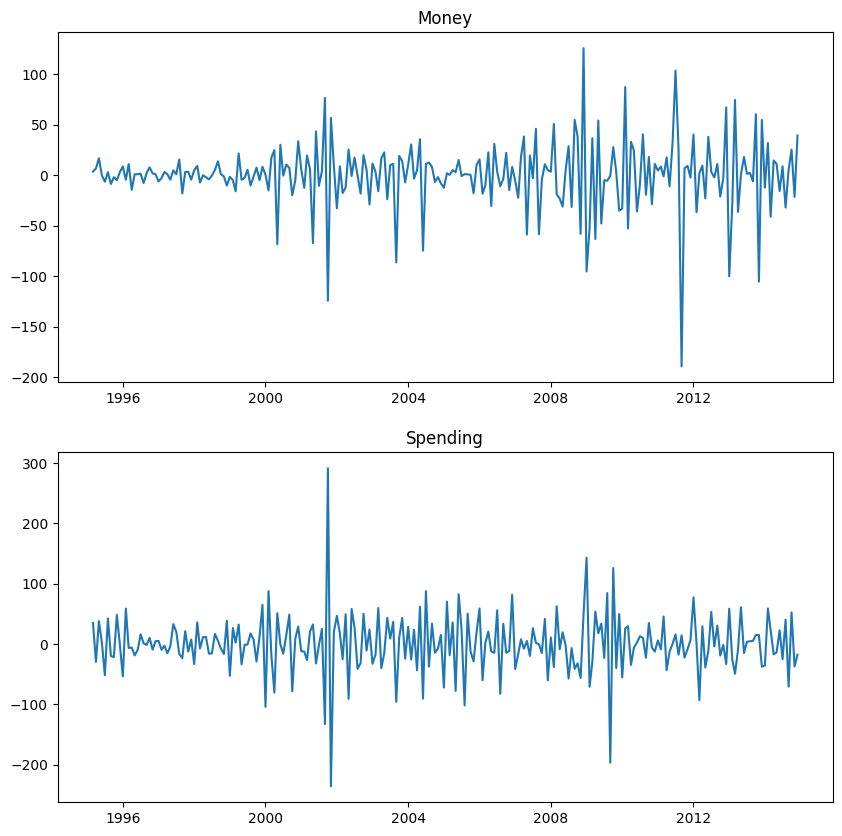

In [33]:
results.plot();

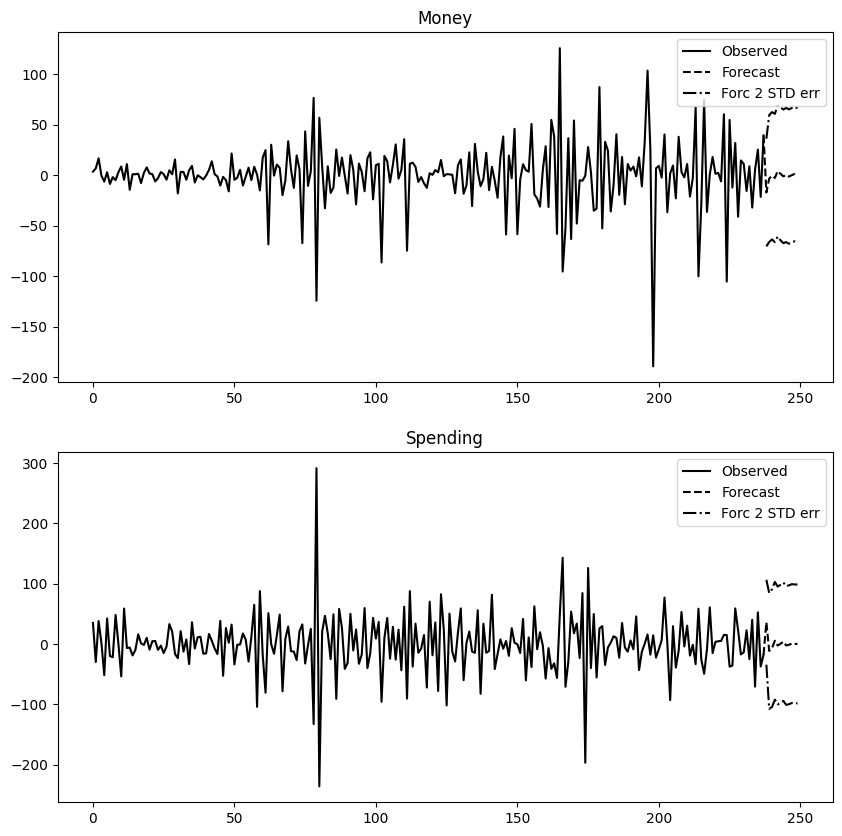

In [34]:
# 예측 포함 시각화
results.plot_forecast(12);

In [35]:
# Test 데이터셋과 예측 결과 비교 시각화
fig = make_subplots(rows=2, cols=1)
fig.add_trace(go.Scatter(x=df.index[-nobs:], y=df['Money'][-nobs:], name='Money'), row=1, col=1)
fig.add_trace(go.Scatter(x=forecast_df.index, y=forecast_df['MoneyForecast'], name='Money Forecast'), row=1, col=1)
fig.add_trace(go.Scatter(x=df.index[-nobs:], y=df['Spending'][-nobs:], name='Spending'), row=2, col=1)
fig.add_trace(go.Scatter(x=forecast_df.index, y=forecast_df['SpendingForecast'], name='Spending Forecast'), row=2, col=1)
fig.update_layout(height=800)
fig.show()

평가

In [36]:
VAR5_RMSE_Money = rmse(df['Money'][-nobs:], forecast_df['MoneyForecast'])
VAR5_RMSE_Spending = rmse(df['Spending'][-nobs:], forecast_df['SpendingForecast'])
print(f"VAR(5)_RMSE_Money: {VAR5_RMSE_Money}")
print(f"VAR(5)_RMSE_Spending: {VAR5_RMSE_Spending}")

VAR(5)_RMSE_Money: 43.710496535589265
VAR(5)_RMSE_Spending: 37.001175169408036


### AR(5) 모델과 비교

In [37]:
# 앞에서 다루지 않은 부분으로, AR만 단독 사용시 사용할수 있는 모듈
from statsmodels.tsa.ar_model import AutoReg 

모델링 및 예측

In [38]:
# 단일 시계열 모델이므로 모델이 2개 필요
modelM = AutoReg(train['Money'], lags=5)
modelS = AutoReg(train['Spending'], lags=5)
modelM_fit = modelM.fit()
modelS_fit = modelS.fit()
modelM_forecast = modelM_fit.forecast(steps=nobs).rename('Money2d')
modelS_forecast = modelS_fit.forecast(steps=nobs).rename('Spending2d')

In [39]:
ar_forecast_df = pd.concat([modelM_forecast, modelS_forecast], axis=1)
ar_forecast_df

,Money2d,Spending2d
2015-01-01,-17.119701,30.641068
2015-02-01,-11.528475,-1.792151
2015-03-01,9.827790,-9.189819
2015-04-01,-5.836863,6.747310
2015-05-01,2.339541,-4.427224
2015-06-01,5.375022,-0.626697
2015-07-01,-4.165296,3.493390
2015-08-01,0.501917,-0.933378
2015-09-01,0.898255,-0.926789
2015-10-01,-1.352987,0.963593


역변환

In [40]:
ar_forecast_df['Money1d'] = (df['Money'].iloc[-nobs-1] - df['Money'].iloc[-nobs-2]) + ar_forecast_df['Money2d'].cumsum()
ar_forecast_df['MoneyForecast'] = df['Money'].iloc[-nobs-1] + ar_forecast_df['Money1d'].cumsum()

ar_forecast_df['Spending1d'] = (df['Spending'].iloc[-nobs-1] - df['Spending'].iloc[-nobs-2]) + ar_forecast_df['Spending2d'].cumsum()
ar_forecast_df['SpendingForecast'] = df['Spending'].iloc[-nobs-1] + ar_forecast_df['Spending1d'].cumsum()

In [41]:
ar_forecast_df

,Money2d,Spending2d,Money1d,MoneyForecast,Spending1d,SpendingForecast
2015-01-01,-17.119701,30.641068,61.480299,11731.580299,41.241068,12103.241068
2015-02-01,-11.528475,-1.792151,49.951824,11781.532123,39.448917,12142.689985
2015-03-01,9.827790,-9.189819,59.779614,11841.311736,30.259098,12172.949083
2015-04-01,-5.836863,6.747310,53.942751,11895.254487,37.006408,12209.955491
2015-05-01,2.339541,-4.427224,56.282292,11951.536779,32.579184,12242.534675
2015-06-01,5.375022,-0.626697,61.657314,12013.194093,31.952487,12274.487162
2015-07-01,-4.165296,3.493390,57.492019,12070.686112,35.445877,12309.933039
2015-08-01,0.501917,-0.933378,57.993936,12128.680048,34.512499,12344.445539
2015-09-01,0.898255,-0.926789,58.892191,12187.572238,33.585710,12378.031249
2015-10-01,-1.352987,0.963593,57.539203,12245.111442,34.549303,12412.580551


결과 시각화

In [42]:
# 차트
fig = make_subplots(rows=2, cols=1)

fig.add_trace(go.Scatter(x=df.index[-nobs:], y=df['Money'][-nobs:], name='Money'), row=1, col=1)
fig.add_trace(go.Scatter(x=ar_forecast_df.index, y=ar_forecast_df['MoneyForecast'], name='Money Forecast'), row=1, col=1)
fig.add_trace(go.Scatter(x=df.index[-nobs:], y=df['Spending'][-nobs:], name='Spending'), row=2, col=1)
fig.add_trace(go.Scatter(x=ar_forecast_df.index, y=ar_forecast_df['SpendingForecast'], name='Spending Forecast'), row=2, col=1)
fig.update_layout(height=800)
fig.show()

In [43]:
# AR(5) 평가 결과
AR5_RMSE_Money = rmse(df['Money'][-nobs:], ar_forecast_df['MoneyForecast'])
AR5_RMSE_Spending = rmse(df['Spending'][-nobs:], ar_forecast_df['SpendingForecast'])
print('-'*100)
print(f"AR(5) RMSE Money: {AR5_RMSE_Money}")
print(f"AR(5) RMSE Spending: {AR5_RMSE_Spending}")
print('-'*100)
print(f"VAR(5) RMSE Money: {VAR5_RMSE_Money}")
print(f"VAR(5) RMSE Spending: {VAR5_RMSE_Spending}")
print('-'*100)

----------------------------------------------------------------------------------------------------
AR(5) RMSE Money: 34.3936979839303
AR(5) RMSE Spending: 34.26101949655065
----------------------------------------------------------------------------------------------------
VAR(5) RMSE Money: 43.710496535589265
VAR(5) RMSE Spending: 37.001175169408036
----------------------------------------------------------------------------------------------------


다변량 시계열 모델이 데이터 적합에서 더 나쁘게 나왔다. 

VAR(5) 모델에서 에러항을 설명할 다른 설명변수가 필요할수 있다.

___
## VARMA / ARIMA 예측 모델 실습
___

모델 추천

In [ ]:
!pip install pmdarima

In [48]:
from statsmodels.tsa.statespace.varmax import VARMAX

In [49]:
import pmdarima as pm
# pmdarima는 시계열 데이터의 ARIMA 모델을 자동으로 생성해주는 라이브러리.
# 이 라이브러리는 데이터의 최적의 ARIMA 파라미터를 찾기 위해 다양한 조합을 시도하고,
# AIC (Akaike Information Criterion) 값을 기준으로 최적의 모델을 선택해줌.
# 또한, pmdarima는 계절성 데이터에 대한 SARIMA 모델도 지원하며, 
# 데이터의 정상성을 확인하고 차분을 통해 비정상성 제거 기능도 포함.
# 이 라이브러리를 사용하면 복잡한 시계열 모델링 과정을 자동화할 수 있어
# 데이터 과학자와 분석가에게 매우 유용함.

In [50]:
pm.auto_arima(df['Money'], maxiter=1000)

ARIMA(maxiter=1000, order=(1, 2, 1), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [51]:
pm.auto_arima(df['Spending'], maxiter=1000)

ARIMA(maxiter=1000, order=(1, 1, 2), scoring_args={}, suppress_warnings=True)

단일 시계열 모델 ARIMA(1,2,1)과 (1,1,2)가 각 변수에 추천되었다.

2차 차분을 한뒤에, 위 p, q항을 포괄할수 있는 VARMA(1,2) 모델을 통해서 예측을 진행하고 ARIMA와 비교해보자.

데이터 차분

In [52]:
df_transformed = df.diff().diff().dropna()
df_transformed.head()

,Money,Spending
Date,,
1995-03-01,3.7,35.0
1995-04-01,6.9,-29.8
1995-05-01,16.9,38.1
1995-06-01,-0.3,1.5
1995-07-01,-6.2,-51.7


데이터 분할

In [53]:
nobs = 12 # nobs : number of observations
train = df_transformed[:-nobs]
test = df_transformed[-nobs:]

모델링

In [54]:
varma = VARMAX(train, order=(1,2), trend='c')
results = varma.fit(maxiter=1000, disp=False)
results.summary()

/Users/dante/workspace/dante-code/projects/kmu-practical-ds-2025/.conda/lib/python3.12/site-packages/statsmodels/tsa/statespace/varmax.py:160: EstimationWarning:

Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.



Dep. Variable:,"['Money', 'Spending']",No. Observations:,238
Model:,"VARMA(1,2)",Log Likelihood,-2286.479
,+ intercept,AIC,4606.958
Date:,"Sat, 07 Jun 2025",BIC,4665.986
Time:,15:22:39,HQIC,4630.747
Sample:,03-01-1995,,
,- 12-01-2014,,
Covariance Type:,opg,,
Ljung-Box (L1) (Q):,"0.93, 0.00",Jarque-Bera (JB):,"531.73, 113.88"
Prob(Q):,"0.34, 0.95",Prob(JB):,"0.00, 0.00"
Heteroskedasticity (H):,"5.52, 2.92",Skew:,"1.31, -0.32"


예측

In [55]:
df_forecast = results.forecast(12)
df_forecast

,Money,Spending
2015-01-01,-10.790897,37.291257
2015-02-01,-11.107180,-3.862648
2015-03-01,0.457421,-0.332256
2015-04-01,-1.199380,-0.144088
2015-05-01,0.630300,0.202646
2015-06-01,-0.117872,0.118350
2015-07-01,0.319970,0.183776
2015-08-01,0.100669,0.154155
2015-09-01,0.217734,0.170687
2015-10-01,0.156895,0.162250


차분 역변환

In [56]:
df_forecast['Money1d'] = (df['Money'].iloc[-nobs-1] - df['Money'].iloc[-nobs-2]) + df_forecast['Money'].cumsum()
df_forecast['MoneyForecast'] = df['Money'].iloc[-nobs-1] + df_forecast['Money1d'].cumsum()
df_forecast['Spending1d'] = (df['Spending'].iloc[-nobs-1] - df['Spending'].iloc[-nobs-2]) + df_forecast['Spending'].cumsum()
df_forecast['SpendingForecast'] = df['Spending'].iloc[-nobs-1] + df_forecast['Spending1d'].cumsum()
df_forecast

,Money,Spending,Money1d,MoneyForecast,Spending1d,SpendingForecast
2015-01-01,-10.790897,37.291257,67.809103,11737.909103,47.891257,12109.891257
2015-02-01,-11.107180,-3.862648,56.701923,11794.611026,44.028609,12153.919866
2015-03-01,0.457421,-0.332256,57.159344,11851.770370,43.696352,12197.616218
2015-04-01,-1.199380,-0.144088,55.959964,11907.730334,43.552264,12241.168482
2015-05-01,0.630300,0.202646,56.590264,11964.320598,43.754910,12284.923392
2015-06-01,-0.117872,0.118350,56.472392,12020.792990,43.873261,12328.796653
2015-07-01,0.319970,0.183776,56.792362,12077.585352,44.057037,12372.853690
2015-08-01,0.100669,0.154155,56.893031,12134.478382,44.211192,12417.064882
2015-09-01,0.217734,0.170687,57.110765,12191.589147,44.381879,12461.446761
2015-10-01,0.156895,0.162250,57.267660,12248.856807,44.544128,12505.990889


데이터 정리 / 결과 시각화

In [57]:
df_forecast

,Money,Spending,Money1d,MoneyForecast,Spending1d,SpendingForecast
2015-01-01,-10.790897,37.291257,67.809103,11737.909103,47.891257,12109.891257
2015-02-01,-11.107180,-3.862648,56.701923,11794.611026,44.028609,12153.919866
2015-03-01,0.457421,-0.332256,57.159344,11851.770370,43.696352,12197.616218
2015-04-01,-1.199380,-0.144088,55.959964,11907.730334,43.552264,12241.168482
2015-05-01,0.630300,0.202646,56.590264,11964.320598,43.754910,12284.923392
2015-06-01,-0.117872,0.118350,56.472392,12020.792990,43.873261,12328.796653
2015-07-01,0.319970,0.183776,56.792362,12077.585352,44.057037,12372.853690
2015-08-01,0.100669,0.154155,56.893031,12134.478382,44.211192,12417.064882
2015-09-01,0.217734,0.170687,57.110765,12191.589147,44.381879,12461.446761
2015-10-01,0.156895,0.162250,57.267660,12248.856807,44.544128,12505.990889


In [58]:
# 두 변수에 대한 테스트셋과 예측치만 남기고 정리
df_forecast = pd.concat([df[['Money', 'Spending']].iloc[-nobs:], df_forecast[['MoneyForecast', 'SpendingForecast']]], axis=1)

In [60]:
df_forecast[['Money', 'MoneyForecast']].plot()

In [61]:
df_forecast[['Spending', 'SpendingForecast']].plot()

In [62]:
varma_1_2_money_rmse = rmse(df[['Money']].iloc[-nobs:], df_forecast[['MoneyForecast']])[0]
varma_1_2_spending_rmse = rmse(df[['Spending']].iloc[-nobs:], df_forecast[['SpendingForecast']])[0]
print('VARMA(1,2) Money RMSE: ', varma_1_2_money_rmse)
print('VARMA(1,2) Spending RMSE: ', varma_1_2_spending_rmse)

VARMA(1,2) Money RMSE:  34.18186025015879
VARMA(1,2) Spending RMSE:  66.73102961893895


### ARMA(1,0,2) 비교
* 위에서 train, test 데이터를 만들때 2차 차분을 이미 진행했으므로 ARIMA(1,2,2) 를 사용하지 않고 ARMA(1,0,2) 사용한다.

In [63]:
from statsmodels.tsa.arima.model import ARIMA

모델링 / 적합

In [69]:
# money 컬럼 모델
arma_money_model = ARIMA(train['Money'], order=(1,0,2))
arma_money_model_fit = arma_money_model.fit()
arma_money_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Money   No. Observations:                  238
Model:                 ARIMA(1, 0, 2)   Log Likelihood               -1117.710
Date:                Sat, 07 Jun 2025   AIC                           2245.421
Time:                        15:24:04   BIC                           2262.782
Sample:                    03-01-1995   HQIC                          2252.418
                         - 12-01-2014                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1814      0.032      5.639      0.000       0.118       0.244
ar.L1         -0.3570      0.176     -2.032      0.042      -0.701      -0.013
ma.L1         -0.4085      2.449     -0.167      0.868      -5.209       4.392
ma.L2         -0.5914      1.403     -0.422      0.673      -3.341       2.158
sigma2       687.1733   1660.749      0.414      0.679   -2567.835    3942.181
===================================================================================
Ljung-Box (L1) (Q):                   0.34   Jarque-Bera (JB):               775.39
Prob(Q):                              0.56   Prob(JB):                         0.00
Heteroskedasticity (H):               6.83   Skew:                             1.61
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.23
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [65]:
# spending 컬럼 모델
arma_spending = ARIMA(train['Spending'], order=(1,0,2))
arma_spending_fit = arma_spending.fit()
arma_spending_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:               Spending   No. Observations:                  238
Model:                 ARIMA(1, 0, 2)   Log Likelihood               -1182.411
Date:                Sat, 07 Jun 2025   AIC                           2374.823
Time:                        15:23:07   BIC                           2392.184
Sample:                    03-01-1995   HQIC                          2381.820
                         - 12-01-2014                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0856      0.279      0.307      0.759      -0.461       0.632
ar.L1         -0.3403      0.545     -0.624      0.532      -1.408       0.728
ma.L1         -0.6451      0.549     -1.174      0.240      -1.722       0.432
ma.L2         -0.2139      0.507     -0.422      0.673      -1.207       0.779
sigma2      1201.3966     66.509     18.064      0.000    1071.042    1331.751
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               184.55
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               2.72   Skew:                            -0.17
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.30
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

예측

In [70]:
arma_money2d_forecast = arma_money_model_fit.forecast(steps=nobs).rename('Forecast_Money2d')
arma_spending2d_forecast = arma_spending_fit.forecast(steps=nobs).rename('Forecast_Spending2d')

차분 역변환

In [71]:
money1d = df['Money'].iloc[-nobs-1] - df['Money'].iloc[-nobs-2] + arma_money2d_forecast.cumsum()
money_forecast = df['Money'].iloc[-nobs-1] + money1d.cumsum()

spending1d = df['Spending'].iloc[-nobs-1] - df['Spending'].iloc[-nobs-2] + arma_spending2d_forecast.cumsum()
spending_forecast = df['Spending'].iloc[-nobs-1] + spending1d.cumsum()

평가

In [72]:
arma_money_rmse = rmse(df['Money'][-nobs:], money_forecast)
arma_spending_rmse = rmse(df['Spending'][-nobs:], spending_forecast)
print('-'*100)
print(f"AR(5) RMSE Money: {AR5_RMSE_Money}")
print(f"AR(5) RMSE Spending: {AR5_RMSE_Spending}")
print('-'*100)
print(f"VAR(5) RMSE Money: {VAR5_RMSE_Money}")
print(f"VAR(5) RMSE Spending: {VAR5_RMSE_Spending}")
print('-'*100)
print(f"ARMA(1,0,2) Money RMSE: {arma_money_rmse}")
print(f"ARMA(1,0,2) Spending RMSE: {arma_spending_rmse}")
print('-'*100)
print('VARMA(1,2) Money RMSE: ', varma_1_2_money_rmse)
print('VARMA(1,2) Spending RMSE: ', varma_1_2_spending_rmse)
print('-'*100)


----------------------------------------------------------------------------------------------------
AR(5) RMSE Money: 34.3936979839303
AR(5) RMSE Spending: 34.26101949655065
----------------------------------------------------------------------------------------------------
VAR(5) RMSE Money: 43.710496535589265
VAR(5) RMSE Spending: 37.001175169408036
----------------------------------------------------------------------------------------------------
ARMA(1,0,2) Money RMSE: 32.6847646606814
ARMA(1,0,2) Spending RMSE: 52.33218456643306
----------------------------------------------------------------------------------------------------
VARMA(1,2) Money RMSE:  34.18186025015879
VARMA(1,2) Spending RMSE:  66.73102961893895
----------------------------------------------------------------------------------------------------


In [78]:
pd.DataFrame({'AR(5)': [AR5_RMSE_Money, AR5_RMSE_Spending],
              'VAR(5)': [VAR5_RMSE_Money, VAR5_RMSE_Spending],
              'ARMA(1,0,2)': [arma_money_rmse, arma_spending_rmse],
              'VARMA(1,2)': [varma_1_2_money_rmse, varma_1_2_spending_rmse]},
              index=['Money', 'Spending']).T.plot.bar(title='평가결과 비교').update_layout(xaxis_title='모델', yaxis_title='RMSE')